In [3]:
#!/usr/bin/env python3

import pandas as pd
import errno    
import os
import numpy as np
import math

#pd.set_option('display.max_rows', 4000)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)

'''
Author: Enrico Ceccolini
    TODO write the description
'''

datadir = "/datasets/eurora_data/db1/"
infile_jobs_to_nodes = datadir + "job_nodes.csv"
infile_nodes = datadir + "nodes.csv"

suffix = "_5sec_"
### select an interval from
## 1 settings wholeData
#interval_comment_whole = "WholeData"

### select an interval from
## 2 settings Andrea
interval_comment = "Andrea"
start_time = pd.to_datetime('2014-03-31')
end_time = pd.to_datetime('2014-05-01')
#infile_jobs = datadir + "april_long_jobs.csv"

## 3 settings Alina
#interval_comment = "Alina"
#start_time = pd.to_datetime('2014-06-30')
#end_time = pd.to_datetime('2014-11-01')


infile_long_jobs = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_long_jobs_real_pow"

## notice that 43 doesn't exists in the db
#nodes=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64']
#nodes=['01'] # test

In [4]:
jobs_to_nodes_whole_data = pd.read_csv(infile_jobs_to_nodes, index_col=0)
print("jobs_to_nodes_whole_data contains {} records".format(jobs_to_nodes_whole_data.shape[0]))

long_jobs = pd.read_csv(infile_long_jobs + ".csv", index_col=0)
print("There are {} long jobs in the {}'s interval".format(long_jobs.shape[0], interval_comment))

jobs_to_nodes_whole_data contains 469095 records
There are 35284 long jobs in the Andrea's interval


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
### clean the data
# remove jobs runned on the inexistent node 129
jobs_to_nodes_whole_data = jobs_to_nodes_whole_data[jobs_to_nodes_whole_data['node_id'] != 129] 
# remove jobs with the same id that runned on the same node
jobs_to_nodes_whole_data = jobs_to_nodes_whole_data.drop_duplicates(subset=['job_id_string', 'node_id'])
print("after the clean, jobs_to_nodes_whole_data contains {} records".format(jobs_to_nodes_whole_data.shape[0]))

after the clean, jobs_to_nodes_whole_data contains 444610 records


In [6]:
### merge the info from the two tables
merged_jobs_to_nodes = pd.merge(long_jobs, jobs_to_nodes_whole_data, how='left', on='job_id_string')
print("merged_jobs_to_nodes contains {} records".format(merged_jobs_to_nodes.shape[0]))

merged_jobs_to_nodes contains 41216 records


In [7]:
nodes = pd.read_csv(infile_nodes, index_col=0)
#print(nodes.shape[0])
#nodes.head()

In [8]:
# create the file where to calculate the approximated consumption
### part 1
infile_node = datadir + "CPUs/" + interval_comment + "/node01" + suffix + interval_comment + "_active_cores_and_jobs"
node_data = pd.read_csv(infile_node + ".csv")

all_time_interval_power_consumption = pd.DataFrame(node_data['timestamp'])
infile_validate_approx = datadir + "CPUs/" + interval_comment + "/validate_approx_" + interval_comment + ".csv"
all_time_interval_power_consumption.to_csv(infile_validate_approx)


### part 2
#all_time_interval_power_consumption = pd.read_csv(infile_validate_approx, index_col=0)
#all_time_interval_power_consumption.shape

In [9]:
#all_time_interval_power_consumption

In [10]:

# per ogni nodo sommo quanto è stato il consumo ad ogni intervallo in un vettore parallelo
# questo sia per il valore approssimato guardando i job
# sia per il valore reale
j = 0
for node_index, node_row in nodes.iterrows():
    node_id = node_row['node_id']
    if( int(node_id) < 10):
        node_id = "0" + str(node_id)
    else:
        node_id = str(node_id)
    print(node_id)
    node_core_idle = node_row['core_idle']
    
    if (node_id != "43"):
        total_real_power_consumption, total_approx_power_consumption = calculate_power_consumption(node_id, node_core_idle)
        all_time_interval_power_consumption[node_id + "_real"] = total_real_power_consumption
        all_time_interval_power_consumption[node_id + "_approx"] = total_approx_power_consumption
    

    all_time_interval_power_consumption.to_csv(infile_validate_approx)

01
443
02
191
03
409
04
384
05
358
06
334
07
335
08
356
09
266
10
308
11
294
12
308
13
295
14
280
15
286
16
288
17
468
18
178
19
273
20
283
21
270
22
3
23
290
24
237
25
264
26
191
27
270
28
233
29
246
30
215
31
202
32
218
33
2358
34
1649
35
1030
36
1295
37
1081
38
942
39
101
40
1116
41
3
42
845
43
44
1909
45
1551
46
795
47
731
48
694
49
1490
50
973
51
905
52
598
53
13
54
689
55
1802
56
677
57
828
58
916
59
2828
60
1007
61
856
62
727
63
627
64
1204


In [23]:
#all_time_interval_power_consumption

In [2]:
def calculate_power_consumption(node_str, node_core_idle):
    
    num_minutes = 535680 # number of minutes on the Andrea's interval
    node_start_time = pd.to_datetime('2014-03-31 00:00:00')
    total_approx_power_consumption = pd.Series(0, index=np.arange(num_minutes))
    total_active_cores = pd.Series(0, index=np.arange(num_minutes))
    total_real_power_consumption = pd.Series(0, index=np.arange(num_minutes))
    
    jobs_to_node = merged_jobs_to_nodes[merged_jobs_to_nodes['node_id'] == int(node_str)]
    infile_node = datadir + "CPUs/" + interval_comment + "/node" + node_str + suffix + interval_comment + "_active_cores_and_jobs"
    node_data = pd.read_csv(infile_node + ".csv")
    #print("{}".format(node_data.shape[0]))
    #print("{}".format(jobs_to_node.shape[0]))

    #node_start_time = node_data.iloc[0]['timestamp']
    #num_minutes = node_data.shape[0]
    #power_consumption = pd.Series(0, index=np.arange(num_minutes))
    #active_cores = pd.Series(0, index=np.arange(num_minutes))
    #print("{}".format(node_start_time))
    
    power_consumption = pd.Series(0, index=np.arange(num_minutes))
    active_cores = pd.Series(0, index=np.arange(num_minutes))
    
    i = 0
    num_jobs = jobs_to_node.shape[0]
    print("{}".format(num_jobs))
    for job_index, job_row in jobs_to_node.iterrows():
        
        #print("{}/{}".format(i, num_jobs))
        i = i + 1
        job_start_time = pd.to_datetime(job_row['run_start_time'])
        job_end_time = pd.to_datetime(job_row['end_time'])
        job_cores = job_row['ncpus']
        job_cores_total = job_row['cpu_req']
        #job_gpus = row['ngpus']
        #job_mics = row['nmics']
        job_power_consumption = job_row['real_pow'] * (job_cores / job_cores_total) # real_pow contains the total, here we need only the node portion
        # print(job_power_consumption)

        before_minutes = int((job_start_time - pd.to_datetime(node_start_time) - np.timedelta64(5, 's')) / np.timedelta64(5, 's'))
        running_minutes = int((job_end_time - job_start_time) / np.timedelta64(5, 's'))
        after_minutes = num_minutes - running_minutes - before_minutes

        #print("{} - {} - {}".format(before_minutes, running_minutes, after_minutes))
        before_serie = pd.Series(0, index=np.arange(before_minutes))
        running_serie = pd.Series(job_power_consumption, index=np.arange(running_minutes))
        after_serie = pd.Series(0, index=np.arange(after_minutes))
        concat_series = pd.concat([before_serie, running_serie, after_serie], ignore_index=True)
        power_consumption = power_consumption.add(concat_series, fill_value=0)

        running_serie = pd.Series(job_cores, index=np.arange(running_minutes))
        concat_series = pd.concat([before_serie, running_serie, after_serie], ignore_index=True)
        active_cores = active_cores.add(concat_series, fill_value=0)

        
    for x in range(0, 17):
        # active_cores[active_cores == x] += (node_core_idle * 16) * (16 - x) / 16
        active_cores[active_cores == x] += node_core_idle * (16 - x)
    
    power_consumption = power_consumption.add(active_cores, fill_value=0)
        
    indices = node_data['active_cores'] == 0
    node_data.at[indices, 'pow_tot'] = node_core_idle * 16
    total_real_power_consumption = node_data['pow_tot']
    
    return total_real_power_consumption, power_consumption

In [11]:
all_time_interval_power_consumption = all_time_interval_power_consumption[pd.to_datetime(all_time_interval_power_consumption['timestamp']) >= pd.to_datetime('2014-03-31 11:21:00')]
all_time_interval_power_consumption = all_time_interval_power_consumption[pd.to_datetime(all_time_interval_power_consumption['timestamp']) <= pd.to_datetime('2014-04-30 20:32:00')]

In [12]:
#all_time_interval_power_consumption = all_time_interval_power_consumption.fillna(55.52)

In [13]:
real = all_time_interval_power_consumption.select(lambda col: col.endswith("real"), axis=1)
approx = all_time_interval_power_consumption.select(lambda col: col.endswith("approx"), axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  


In [14]:
real['Total']= real.iloc[:, -63:-1].sum(axis=1)
approx['Total']= approx.iloc[:, -63:-1].sum(axis=1)
differences = real['Total'] - approx['Total']
df = pd.DataFrame(differences)
df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
differences_norm = df['Total']

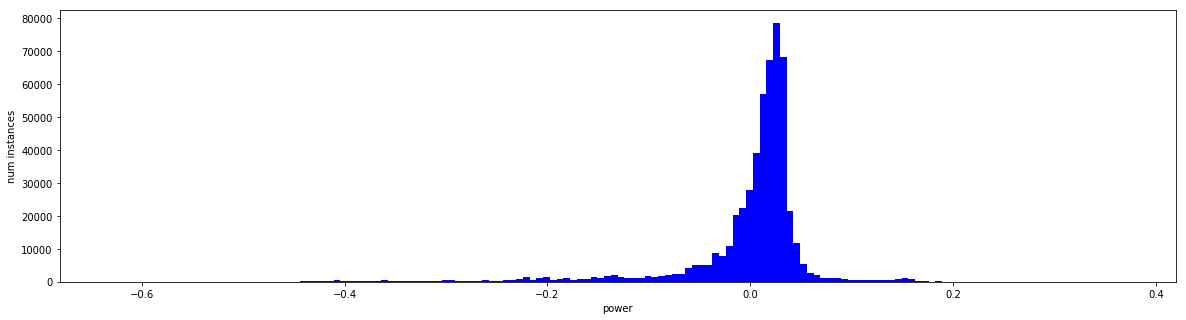

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = (20,5)

num_bins = 150
n, bins, patches = plt.hist(differences_norm, num_bins, facecolor='blue', alpha=1)
#plt.axis([-0.4, 0.4, 0, 600])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()